In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

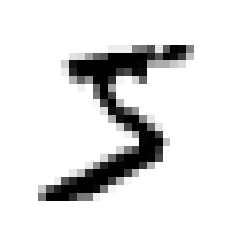

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np

# 레이블이 문자열이므로 정수로 변환
y = y.astype(np.uint8)

In [6]:
# mnist 데이터셋은 60000을 기준으로 훈련 세트와 테스트 세트가 이미 분리되어있는 데이터셋임
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 

'5'와 '5가 아님' 2개의 클래스를 분류하는 이진 분류기

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGD는 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터셋을 효율적으로 처리하는 장점

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDClassifier 모델로 숫자 5의 이미지를 테스트

In [9]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

### 교차 검증을 사용한 정확도 측정

In [10]:
# 훈련 세트를 3개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# StratifiedKFold : 클래스 별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

분류기의 성능 측정 지표로는 정확도를 선호하지 않는다. 

특히 불균형한 데이터셋을 다룰 때는 더욱 그렇다.

### 오차 행렬 Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### 정밀도와 재현율

정밀도는 P로 예측한 것들 중에 실제 P인 것<br/>
이는 분류기가 다른 모든 양성 샘플을 무시하기에 유용하지 않다.


재현율은 분류기가 정확하게 감지한 양성 샘플의 비율

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 score은 정밀도와 재현율의 조화 평균

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도/재현율 트레이드오프

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.legend(loc='center right', fontsize=15)
    plt.xlabel("임계값", fontsize=15)
    plt.grid(True)

In [30]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rc("font", family="Malgun Gothic")

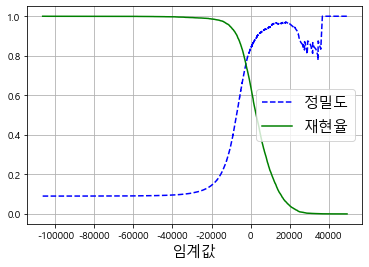

In [31]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

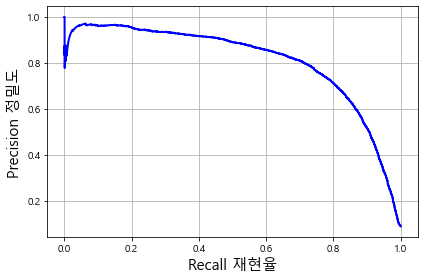

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall 재현율", fontsize=15)
    plt.ylabel("Precision 정밀도", fontsize=15)
    plt.grid(True)
    
plot_precision_vs_recall(precisions, recalls)
plt.tight_layout()
plt.show()

In [42]:
# 정밀도가 90%가 되는 가장 낮은 임계값
threshold_90_precision = thresholds[np.argmax(precision >= 0.9)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

정밀도가 90%인 분류기임을 확인할 수 있음

### ROC 곡선

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

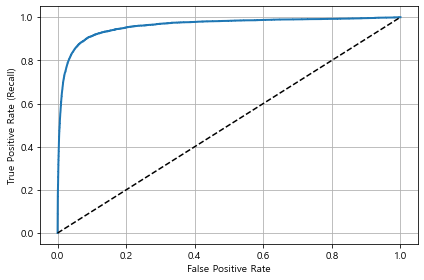

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.tight_layout()
plt.show()

재현율이 높을수록 분류기가 만드는 FPR(거짓 양성)이 증가한다.


좋은 분류기는 이 점선에서 최대한 멀리 떨어져있어야한다.

In [53]:
# 곡선 아래 면적 (area under the curve) AUC 

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 랜덤포레스트Classifier과 SGD Classifier의 ROC 곡선과 ROC AUC 점수 비교

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method='predict_proba')

In [58]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

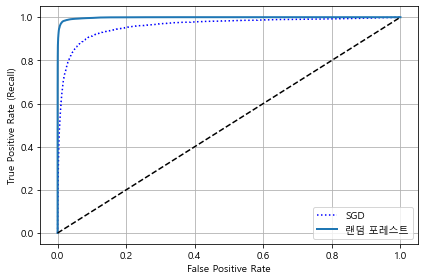

In [63]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

랜덤포레스트 Classifier가 훨씬 좋음

In [64]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145